# Very simple Normalizing Flows in Torch

## Target distribution to sample from

We will sample from a mixture of 2D Gaussians. The target distribution is defined as follows:

$$
p(x_1, x_2) = N(x_1|\frac{1}{4x_2^2}, 1) \cdot N(x_2|0,4)
$$

In [41]:
import numpy as np
import torch
from torch import nn

# target distribution implementation from https://github.com/VincentStimper/normalizing-flows/tree/master

class Target(nn.Module):
    """
    Sample target distributions to test models
    """

    def __init__(self, prop_scale=torch.tensor(6.0), prop_shift=torch.tensor(-3.0)):
        """Constructor

        Args:
          prop_scale: Scale for the uniform proposal
          prop_shift: Shift for the uniform proposal
        """
        super().__init__()
        self.register_buffer("prop_scale", prop_scale)
        self.register_buffer("prop_shift", prop_shift)

    def log_prob(self, z):
        """
        Args:
          z: value or batch of latent variable

        Returns:
          log probability of the distribution for z
        """
        raise NotImplementedError("The log probability is not implemented yet.")

    def rejection_sampling(self, num_steps=1):
        """Perform rejection sampling on image distribution

        Args:
          num_steps: Number of rejection sampling steps to perform

        Returns:
          Accepted samples
        """
        eps = torch.rand(
            (num_steps, self.n_dims),
            dtype=self.prop_scale.dtype,
            device=self.prop_scale.device,
        )
        z_ = self.prop_scale * eps + self.prop_shift
        prob = torch.rand(
            num_steps, dtype=self.prop_scale.dtype, device=self.prop_scale.device
        )
        prob_ = torch.exp(self.log_prob(z_) - self.max_log_prob)
        accept = prob_ > prob
        z = z_[accept, :]
        return z

    def sample(self, num_samples=1):
        """Sample from image distribution through rejection sampling

        Args:
          num_samples: Number of samples to draw

        Returns:
          Samples
        """
        z = torch.zeros(
            (0, self.n_dims), dtype=self.prop_scale.dtype, device=self.prop_scale.device
        )
        while len(z) < num_samples:
            z_ = self.rejection_sampling(num_samples)
            ind = np.min([len(z_), num_samples - len(z)])
            z = torch.cat([z, z_[:ind, :]], 0)
        return z

class TwoMoons(Target):
    """
    Bimodal two-dimensional distribution
    """

    def __init__(self):
        super().__init__()
        self.n_dims = 2
        self.max_log_prob = 0.0

    def log_prob(self, z):
        """
        ```
        log(p) = - 1/2 * ((norm(z) - 2) / 0.2) ** 2
                 + log(  exp(-1/2 * ((z[0] - 2) / 0.3) ** 2)
                       + exp(-1/2 * ((z[0] + 2) / 0.3) ** 2))
        ```

        Args:
          z: value or batch of latent variable

        Returns:
          log probability of the distribution for z
        """
        a = torch.abs(z[:, 0])
        log_prob = (
            -0.5 * ((torch.norm(z, dim=1) - 2) / 0.2) ** 2
            - 0.5 * ((a - 2) / 0.3) ** 2
            + torch.log(1 + torch.exp(-4 * a / 0.09))
        )
        return log_prob


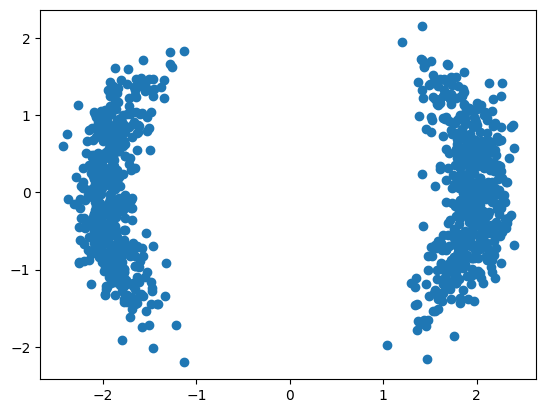

In [3]:
import matplotlib.pyplot as plt

target = TwoMoons()
z = target.sample(1000)
plt.scatter(z[:, 0], z[:, 1])
plt.show()

In [36]:
# Multilayer perceptron
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers) - 2):
            net.append(nn.Linear(layers[k], layers[k + 1]))
            net.append(nn.LeakyReLU(0.0))
        
        net.append(nn.Linear(layers[-2], layers[-1]))
        nn.init.zeros_(net[-1].weight)
        nn.init.zeros_(net[-1].bias)

        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

In [ ]:

# RealNVP coupling layer 
"""
    ```
    f(z) = b * z + (1 - b) * (z * exp(s(b * z)) + t)
    ```
"""
class MaskedAffineFlow(nn.Module):
    def __init__(self, b, t, s):
        super().__init__()
        self.b_cpu = b.view(1, *b.size())
        self.register_buffer("b", self.b_cpu)
        self.add_module("s", s)
        self.add_module("t", t)

    def forward(self, z):
        z_masked = self.b * z
        scale = self.s(z_masked)
        nan = torch.tensor(np.nan, dtype=z.dtype, device=z.device)
        scale = torch.where(torch.isfinite(scale), scale, nan)
        trans = self.t(z_masked)
        trans = torch.where(torch.isfinite(trans), trans, nan)
        z_ = z_masked + (1 - self.b) * (z * torch.exp(scale) + trans)
        log_det = torch.sum((1 - self.b) * scale, dim=list(range(1, self.b.dim())))
        return z_, log_det

    def inverse(self, z):
        z_masked = self.b * z
        
        scale = self.s(z_masked.to(torch.float32))
        nan = torch.tensor(np.nan, dtype=z.dtype, device=z.device)
        scale = torch.where(torch.isfinite(scale), scale, nan)
        trans = self.t(z_masked.to(torch.float32))
        trans = torch.where(torch.isfinite(trans), trans, nan)
        z_ = z_masked + (1 - self.b) * (z - trans) * torch.exp(-scale)
        log_det = -torch.sum((1 - self.b) * scale, dim=list(range(1, self.b.dim())))
        return z_, log_det

In [42]:
# scale and shift flow
class AffineCoupling(nn.Module):
    def __init__(self, shape, scale=True, shift=True):
        super().__init__()
        self.s = nn.Parameter(torch.zeros(shape)[None])
        self.t = nn.Parameter(torch.zeros(shape)[None])
        self.n_dim = self.s.dim()
        self.batch_dims = torch.nonzero(
            torch.tensor(self.s.shape) == 1, as_tuple=False
        )[:, 0].tolist()

    def forward(self, z):
        z_ = z * torch.exp(self.s) + self.t
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = prod_batch_dims * torch.sum(self.s)
        return z_, log_det

    def inverse(self, z):
        z_ = (z - self.t) * torch.exp(-self.s)
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = -prod_batch_dims * torch.sum(self.s)
        return z_, log_det


In [43]:

# Normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, base_dist, flows, target):
        super().__init__()
        self.base_dist = base_dist
        self.flows = nn.ModuleList(flows)
        self.target = target
    
    def reverse_kld(self, num_samples, beta=1.0):
        z, log_q_ = self.base_dist(num_samples)
        log_q = torch.zeros_like(log_q_)
        log_q += log_q_
        for flow in self.flows:
            z, log_det = flow(z.to(torch.float32))
            log_q -= log_det
        log_p = self.target.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)
    
    def forward_kld(self, x):
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.base_dist.log_prob(z)
        return -torch.mean(log_q)
    
    def sample(self, num_samples):
        z, log_q = self.base_dist(num_samples)
        for flow in self.flows:
            z, log_det = flow(z.to(torch.float32))
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.base_dist.log_prob(z)
        return log_q


In [44]:
n_layers = 32

# RealNVP

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(n_layers):
    s = MLP([latent_size, 2 * latent_size, latent_size])
    t = MLP([latent_size, 2 * latent_size, latent_size])
    if i % 2 == 0:
        flows += [MaskedAffineFlow(b, t, s)]
    else:
        flows += [MaskedAffineFlow(1 - b, t, s)]
    flows += [AffineCoupling(latent_size)]


base_dist = nf.distributions.DiagGaussian(2)

model = NormalizingFlow(base_dist, flows, target)


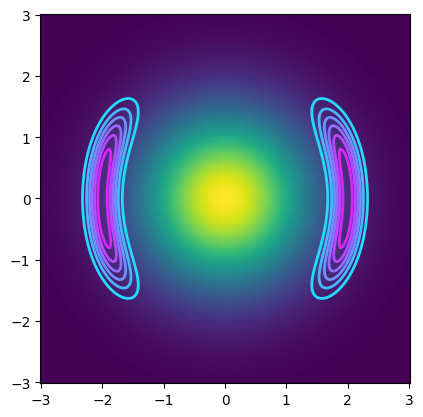

In [45]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double()
log_prob = target.log_prob(zz).view(*xx.shape)
prob_target = torch.exp(log_prob)

# Plot initial posterior distribution
log_prob = model.log_prob(zz).view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

# plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [47]:
# training
num_samples = 2**9
anneal_iter = 1000
loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
for i in range(4000):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples, beta=np.min([1., 0.001 + i / anneal_iter]))
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    if i % 100 == 0:
        print(f"Loss: {loss}")
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())


Loss: -3.3974015712738037
Loss: -1.7292461395263672
Loss: -0.025580883026123047
Loss: 0.9743168354034424
Loss: 0.851433277130127
Loss: 0.16630101203918457
Loss: 0.13311266899108887
Loss: 0.14258015155792236
Loss: 0.094246506690979
Loss: 0.06358826160430908
Loss: 0.2237628698348999
Loss: 0.011284589767456055
Loss: -0.12758386135101318
Loss: -0.16469430923461914
Loss: -0.3867835998535156
Loss: -0.36514079570770264
Loss: -0.2918684482574463
Loss: -0.47660523653030396
Loss: -0.45480918884277344
Loss: -0.3942958116531372
Loss: -0.505233883857727
Loss: -0.36496198177337646
Loss: -0.5276828408241272
Loss: -0.481953501701355
Loss: -0.4982997179031372
Loss: -0.4952707886695862
Loss: -0.4849817752838135
Loss: -0.5212715864181519
Loss: -0.42088282108306885
Loss: -0.5509363412857056
Loss: -0.5049577951431274
Loss: -0.5862772464752197
Loss: -0.4880690574645996
Loss: -0.572209358215332
Loss: -0.6257004737854004
Loss: -0.5887014269828796
Loss: -0.531043529510498
Loss: -0.695884644985199
Loss: -0.5689

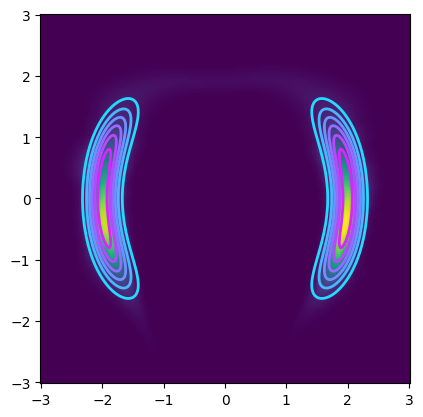

In [48]:
# plotting transformed base distribution

log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()